In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torchvision
from torchvision.models import resnet18
import random

# 检查CUDA是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# 加载预训练的 ResNet-18 模型
model = models.resnet18(pretrained=True)

# 修改模型以输出嵌入向量（移除最后一层分类层）
model = nn.Sequential(*list(model.children())[:-1])
model = model.to(device)  # 将模型移到GPU

# 加载 CIFAR-10 数据集
transform = transforms.Compose([
    transforms.Resize(224),  # 调整 CIFAR-10 图片大小以匹配 ResNet-18 输入要求
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])


Using device: cuda


/home/fu/miniconda3/envs/dbps/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fu/miniconda3/envs/dbps/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
# 加载 CIFAR-10 数据集
trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)

# 随机化 150 张图片的标签
num_random_labels = 15000
num_classes = 10

random_indices = random.sample(range(len(trainset)), num_random_labels)
random_labels = [random.randint(0, num_classes - 1) for _ in range(num_random_labels)]

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for idx, new_label in zip(random_indices, random_labels):
    trainset.targets[idx] = new_label

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=8)


Files already downloaded and verified


Files already downloaded and verified


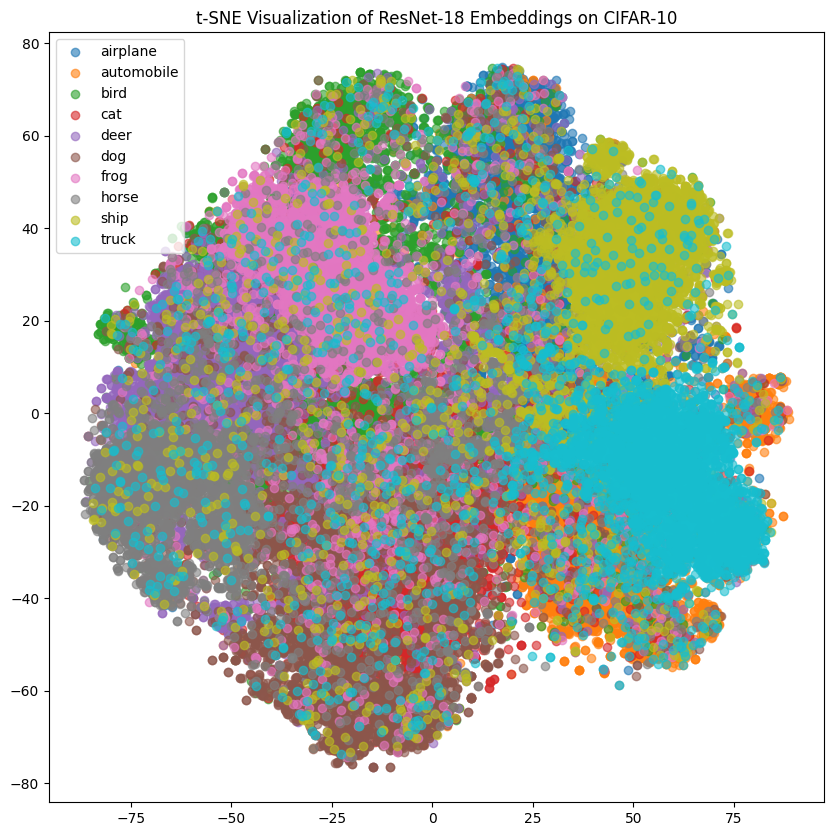

In [3]:
# 获取嵌入向量和标签
model.eval()
embeddings = []
labels = []

with torch.no_grad():
    for images, targets in trainloader:
        images = images.to(device)  # 将图像数据移到GPU
        outputs = model(images).squeeze()
        embeddings.append(outputs.cpu())  # 将结果移回CPU并存储
        labels.append(targets)

embeddings = torch.cat(embeddings).cpu().numpy()
labels = torch.cat(labels).cpu().numpy()

# 使用 t-SNE 将嵌入向量降维到 2D 空间
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# 绘制嵌入向量的 2D 可视化
plt.figure(figsize=(10, 10))
dataset = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)
for i in range(10):
    indices = np.where(labels == i)
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=dataset.classes[i], alpha=0.6)

plt.legend()
plt.title("t-SNE Visualization of ResNet-18 Embeddings on CIFAR-10")
plt.show()
